$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \newcommand{\bnaive}{\widehat{\beta}}
    \newcommand{\bbayes}{\widetilde{\beta}}
    \newcommand{\bboot}{\beta^{*}}
    \newcommand{\bdouble}{\beta^{**}}
    \newcommand{\bbootnv}{\hat{\beta}^*}
    \newcommand{\bbootby}{\widetilde{\beta}^*}
    \newcommand{\bcorrect}{\beta^{\checkmark}}
    \newcommand{\bbayescorrect}{\widetilde{\beta}^{\checkmark}}
    \newcommand{\ybar}{\bar{Y}}
    \newcommand{\ypred}{\widetilde{y}}
    \newcommand{\ybarpred}{\widetilde{\bar{Y}}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\thresh}{\ybar{}_0}
    \newcommand{\muo}{\mu_{0}}
    \newcommand{\sigo}{\sigma_{0}}
    \newcommand{\hmt}{\bar{Y_t}}
    \newcommand{\hst}{s_t^2}
    \newcommand{\hmc}{\bar{Y_c}}
    \newcommand{\hsc}{s_c^2}
    \newcommand{\mt}{\mu_t}
    \newcommand{\sigt}{\sigma_t}
    \newcommand{\vt}{\sigma_t^2}
    \newcommand{\mc}{\mu_c}
    \newcommand{\vc}{\sigma_c^2}
    \newcommand{\sigc}{\sigma_c}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
$$

This is a small simulation experiment to illustrate a difference between regression discontinuity in 1D and 2D. The RDD argument is that near the discontinuity, we basically have a randomized experiments. I argue that in 2D, as we move along the discontinuity, we have *multiple* (correlated) experiments. This **reduces the identifiability problem** between the GP and the treatment effect, and so there is a corresponding reduction in the posterior variance.

I'm still going to use the same constant treatment effect model:

\begin{align}
    Y &\sim \tau \Ind_{\cbr{X>thresh}} + \epsilon
\end{align}

$\epsilon$ is from a GP with a squared exponential covariance with additional iid normal noise with variance $\sigma_y^2$.

$$ K\del{x,x'} = \cov\del{y, y'} = \sigma_y^2 \delta\del{x-x'} + \sigma_f^2 \exp\del{ - \frac{\del{x-x'}^2}{2 L^2}} $$

To illustrate the effect (and reduce confusion), I assume that all the covariance parameters are **fixed and known**.

$x$ is now a two-dimensional vector $(x_1, x_2)$. The discontinuity is in $x_1$. I perform inference twice: first with $x_2$ constant (so we are back in the 1D case), and second with $x_2$ on a grid. I show that going from the 1D to the 2D case **reduces the posterior variance**. See the plots further down of the observation positions for clarification.

In [1]:
import PyPlot
plt=PyPlot
plt.svg(true)
using LaTeXStrings
using GaussianProcesses
using Distributions
import PyPlot; plt=PyPlot
;

# Data Simulations

In [42]:
thresh = 0.0

# data-generating parameters
σf2_star = 1.0
Lstar  = 1.05
τstar = 0.75
σy2_star = 0.1

function simulateGP{T<:Number,S<:Number,Ker<:Kernel}(τ::T, kern::Ker, thresh::Real, X::AbstractArray{S})
    n = size(X,1)
    K = GaussianProcesses.crossKern(X', kern)
    fXdistr = MvNormal(zeros(n), K+ 1e-5*eye(n))
    fX = rand(fXdistr)
    return fX
end

στ2 = 100.0 # diffuse normal prior on τ
kern = SE(log(Lstar), log(√σf2_star))
nx1 = 1000
nx2 = 4
X1 = sort(rand(Normal(), nx1))
X2 = linspace(0, 10, nx2)
X = zeros(Float64, (nx1*nx2,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x1 in X1, x2 in X2]))
    X[i,1] = x1x2[1]
    X[i,2] = x1x2[2]
end

fGP = simulateGP(τstar, kern, thresh, X)
fTreated = copy(fGP)
fTreated[X[:,1].>thresh] += τstar
;

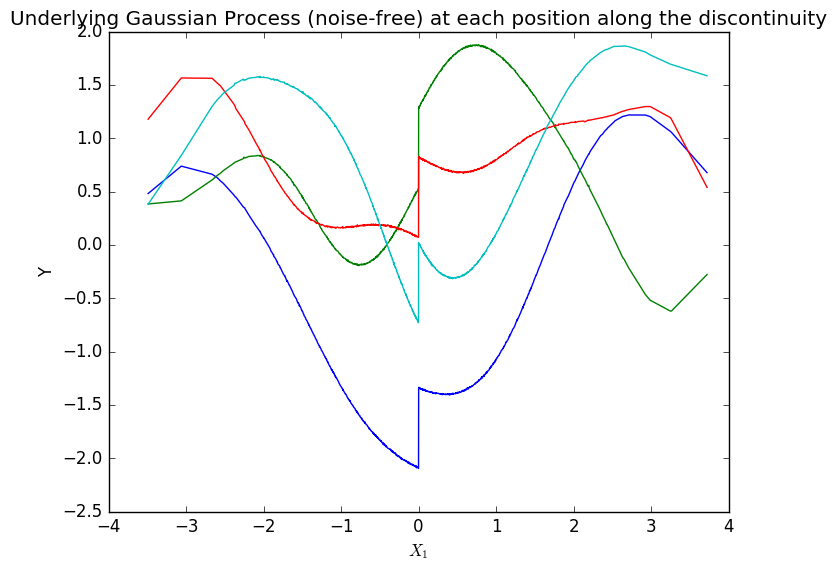

In [43]:
for j in 1:nx2
    plt.plot(X[1:nx1,1], fTreated[(j-1)*nx1+1:j*nx1])
end
plt.title("Underlying Gaussian Process (noise-free) at each position along the discontinuity")
plt.xlabel(L"X_1")
plt.ylabel("Y")
;

**Note**: I reuse the same noise vector for both experiments, to be entirely fair. Also, both experiments have the same number of points.

In [44]:
noise = rand(Normal(0,√σy2_star), nx1*nx2)
Ygrid = fTreated .+ noise
Xline = copy(X)
Xline[:,2] = X2[1]
Yline = repeat(fTreated[1:nx1],outer=[nx2]) .+ noise
;

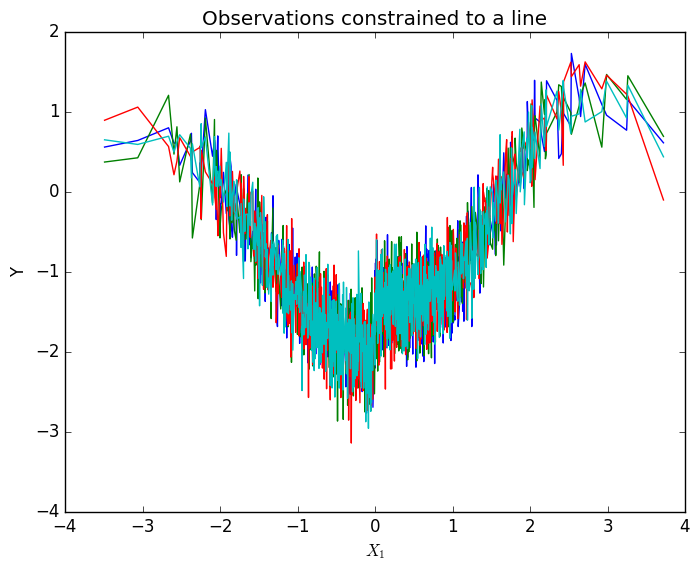

In [45]:
for j in 1:nx2
    plt.plot(Xline[1:nx1,1], Yline[(j-1)*nx1+1:j*nx1])
end
plt.title("Observations constrained to a line")
plt.xlabel(L"X_1")
plt.ylabel("Y")
;

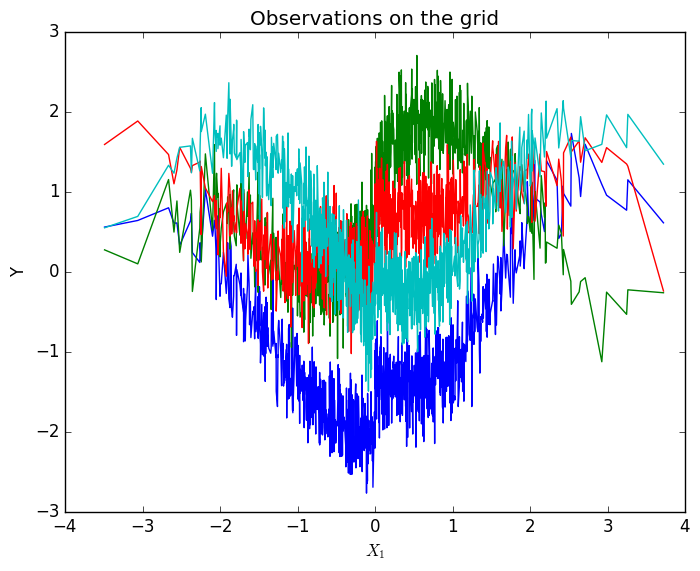

In [46]:
for j in 1:nx2
    plt.plot(X[1:nx1,1], Ygrid[(j-1)*nx1+1:j*nx1])
end
plt.title("Observations on the grid")
plt.xlabel(L"X_1")
plt.ylabel("Y")
;

For inference, I will force a gap around the discontinuity, by deleting all points within $\pm 1$ of the discontinuity.

In [47]:
further = repeat(convert(Array{Bool}, abs(X1).>1.0), outer=[nx2]);

In [48]:
sum(further)

1276

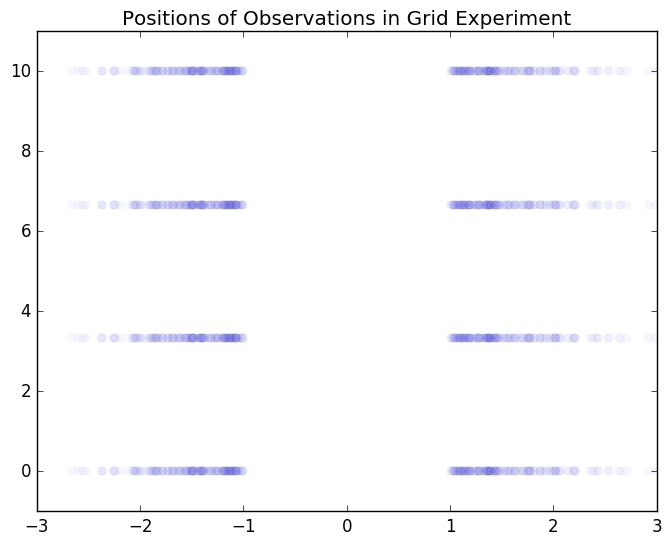

In [49]:
plt.svg(false)
plt.plot(X[further,1], X[further,2], "o", alpha=0.03)
plt.title("Positions of Observations in Grid Experiment")
plt.xlim(-3,3)
plt.ylim(-1,11)
;

In the 1D experiment all points are collapsed onto a single line, but there are still just as many data points (notice the dots are darker).

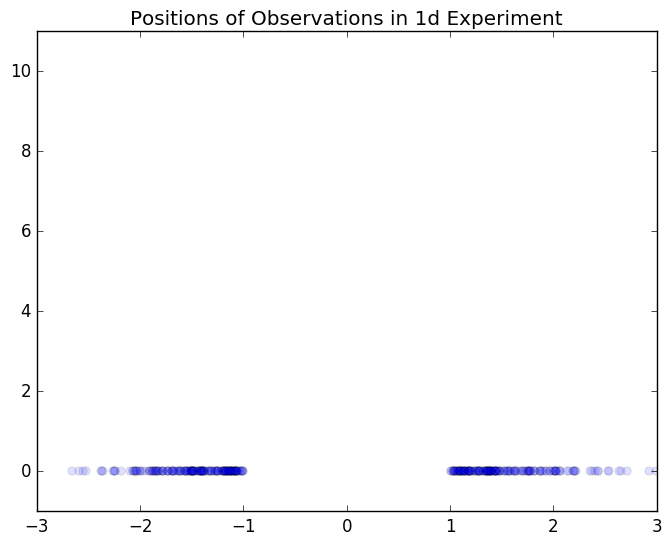

In [50]:
plt.plot(Xline[further,1], Xline[further,2], "o", alpha=0.03)
plt.title("Positions of Observations in 1d Experiment")
plt.xlim(-3,3)
plt.ylim(-1,11)
plt.svg(false)
;

# Inference

In [51]:
function g_VarY{T<:Number, S<:Number}(X::Array{T}, XXt::Symmetric{T}, thresh::T, στ2::T, σβ2::T, σy2::S, σf2::S, L::S)
    n = length(X)
    kern = SE(log(L), log(√σf2))
    In=eye(XXt)
    region = X.>thresh
    II = region * region'
    K = K = GaussianProcesses.crossKern(X', kern)
    VarY = K + στ2*II + σβ2*XXt + (σy2+1e-5)*In
    return VarY
end
function τ_posterior{T<:Real, S<:Number}(X::Array{Float64}, Y::Vector{Float64}, στ2::T, σβ2::T, σy2::S, σf2::S, L::S, thresh::Float64)
    XXt = Symmetric(X * X')
    VarY = PDMats.PDMat(g_VarY(X, XXt, thresh, στ2, σβ2, σy2, σf2, L))
    region = (X.>thresh)*1.0
    II = region * region' # we're doing this twice. expensive?
    alpha = VarY \ Y
    Eτ_Y =(στ2 * region' * alpha)[1]
    Lck = PDMats.whiten(VarY, region'')
    Vτ_Y = (στ2 - στ2^2 .* Lck' * Lck)[1]
    τ_Y = Normal(Eτ_Y, √(Vτ_Y))
    return τ_Y
end

τ_posterior (generic function with 1 method)

In [52]:
τpost_grid = τ_posterior(Xline[further,:], Yline[further], 
        στ2, 0.0, σy2_star, σf2_star, Lstar, thresh)

Distributions.Normal(μ=-0.22796036969810984, σ=0.6430863214720158)

In [53]:
τpost_grid = τ_posterior(X[further,:], Ygrid[further], 
        στ2, 0.0, σy2_star, σf2_star, Lstar, thresh)

Distributions.Normal(μ=-0.06807141579395193, σ=0.4245508784470453)

And we see that the posterior variance $\sigma$ is reduced by going from the 1D experiment to the 2D experiment.